In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re

In [3]:
def extract_lhg(filename: str):

    pattern = r"L(\d+)H(\d+)G(\d+)"
    match = re.search(pattern, filename)

    if not match:
        return None
    
    L, H, G = map(int, match.groups())
    return {"L": L, "H": H, "G": G}

In [4]:
def _compute_spike_mask_phase_space(u: np.ndarray) -> np.ndarray:
    """
    Dado u (señal centrada: sin media), aplica el método de Phase-Space Thresholding
    (pasos 1–5) y devuelve spike_mask (True donde hay spike).

    NO modifica la señal. Solo detecta.
    """
    n = u.size

    # ---------- Paso 1: derivadas Du y D2u ----------
    Du = np.empty_like(u)
    D2u = np.empty_like(u)

    Du[1:-1] = (u[2:] - u[:-2]) / 2.0
    Du[0] = Du[1]
    Du[-1] = Du[-2]

    D2u[1:-1] = (Du[2:] - Du[:-2]) / 2.0
    D2u[0] = D2u[1]
    D2u[-1] = D2u[-2]

    # ---------- Paso 2: desviaciones estándar + Universal Threshold ----------
    su = np.nanstd(u, ddof=0)
    sDu = np.nanstd(Du, ddof=0)
    sD2u = np.nanstd(D2u, ddof=0)

    if su == 0 and sDu == 0 and sD2u == 0:
        return np.zeros_like(u, dtype=bool)

    lambda_U = np.sqrt(2.0 * np.log(n))

    # ---------- Paso 3: ángulo de rotación θ ----------
    sum_u_D2u = np.nansum(u * D2u)
    sum_u2 = np.nansum(u * u)

    if sum_u2 == 0.0:
        theta = 0.0
    else:
        theta = np.arctan2(sum_u_D2u, sum_u2)

    cos_t = np.cos(theta)
    sin_t = np.sin(theta)

    # ---------- Paso 4: parámetros de las elipses ----------
    # 4.A) (u, Du)
    a_u_Du = lambda_U * su
    b_u_Du = lambda_U * sDu

    # 4.B) (Du, D2u)
    a_Du_D2u = lambda_U * sDu
    b_Du_D2u = lambda_U * sD2u

    # 4.C) (u, D2u) rotada
    A = (lambda_U * su) ** 2
    B = (lambda_U * sD2u) ** 2

    cos2 = cos_t * cos_t
    sin2 = sin_t * sin_t
    denom = cos2 * cos2 - sin2 * sin2

    if np.isclose(denom, 0.0):
        a_u_D2u = np.sqrt(max(A, 0.0))
        b_u_D2u = np.sqrt(max(B, 0.0))
    else:
        a2 = (A * cos2 - B * sin2) / denom
        b2 = (B * cos2 - A * sin2) / denom
        a2 = max(a2, 0.0)
        b2 = max(b2, 0.0)
        a_u_D2u = np.sqrt(a2)
        b_u_D2u = np.sqrt(b2)

    # ---------- Paso 5: detección de spikes ----------
    inside_all = np.ones_like(u, dtype=bool)

    # (u, Du)
    if a_u_Du > 0 and b_u_Du > 0:
        x = u
        y = Du
        inside = (x / a_u_Du) ** 2 + (y / b_u_Du) ** 2 <= 1.0
        inside_all &= inside

    # (Du, D2u)
    if a_Du_D2u > 0 and b_Du_D2u > 0:
        x = Du
        y = D2u
        inside = (x / a_Du_D2u) ** 2 + (y / b_Du_D2u) ** 2 <= 1.0
        inside_all &= inside

    # (u, D2u) rotada
    if a_u_D2u > 0 and b_u_D2u > 0:
        x_prime = u * cos_t + D2u * sin_t
        y_prime = -u * sin_t + D2u * cos_t
        inside = (x_prime / a_u_D2u) ** 2 + (y_prime / b_u_D2u) ** 2 <= 1.0
        inside_all &= inside

    spike_mask = ~inside_all
    return spike_mask


def _replace_spikes_cubic(u: np.ndarray, spike_mask: np.ndarray) -> np.ndarray:
    """
    Reemplaza los spikes (True en spike_mask) en la señal centrada u
    usando polinomio cúbico a través de hasta 12 puntos buenos a cada lado.
    Devuelve una nueva versión de u (u_clean).
    """
    u_clean = u.copy()
    n = u.size
    idx = np.arange(n)

    spike_indices = np.where(spike_mask)[0]
    if spike_indices.size == 0:
        return u_clean

    # Agrupar spikes contiguos en eventos [s, e]
    events = []
    start = spike_indices[0]
    prev = spike_indices[0]

    for k in spike_indices[1:]:
        if k == prev + 1:
            prev = k
        else:
            events.append((start, prev))
            start = prev = k
    events.append((start, prev))

    for (s, e) in events:
        left_good = idx[(idx < s) & (~spike_mask)]
        right_good = idx[(idx > e) & (~spike_mask)]

        left_sel = left_good[-12:]
        right_sel = right_good[:12]

        fit_idx = np.concatenate([left_sel, right_sel])

        if fit_idx.size < 4:
            # Fallbacks simples si no hay puntos suficientes para un cúbico
            spike_range = np.arange(s, e + 1)

            if left_sel.size > 0 and right_sel.size > 0:
                x0 = left_sel[-1]
                x1 = right_sel[0]
                y0 = u_clean[x0]
                y1 = u_clean[x1]
                u_clean[spike_range] = np.interp(spike_range, [x0, x1], [y0, y1])
            elif left_sel.size > 0:
                u_clean[spike_range] = u_clean[left_sel[-1]]
            elif right_sel.size > 0:
                u_clean[spike_range] = u_clean[right_sel[0]]
            continue

        x_fit = fit_idx.astype(float)
        y_fit = u_clean[fit_idx]

        degree = 3
        if fit_idx.size <= 3:
            degree = fit_idx.size - 1

        coeffs = np.polyfit(x_fit, y_fit, degree)

        spike_range = np.arange(s, e + 1, dtype=float)
        u_clean[s:e + 1] = np.polyval(coeffs, spike_range)

    return u_clean


def despike_signal(signal: np.ndarray, max_iter: int = 5):
    """
    Versión ITERATIVA del método Phase-Space Thresholding + reemplazo cúbico.

    Devuelve:
      - clean_signal: señal despikeada (con media repuesta)
      - spike_mask_total: máscara booleana OR de todas las iteraciones
      - n_iter: número de iteraciones efectivamente realizadas (>= 0)
    """
    signal = np.asarray(signal, dtype=float)
    mean_u = np.nanmean(signal)
    u_clean = signal - mean_u  # trabajamos centrados

    n = u_clean.size
    if n < 5:
        return signal.copy(), np.zeros_like(signal, dtype=bool), 0

    spike_mask_total = np.zeros_like(u_clean, dtype=bool)
    prev_mask = np.zeros_like(u_clean, dtype=bool)
    n_iter = 0

    for it in range(max_iter):
        # 1) detectar spikes en la señal ACTUAL u_clean
        spike_mask = _compute_spike_mask_phase_space(u_clean)
        spikes_now = spike_mask.sum()

        # contador de iteraciones en las que SÍ llegamos a computar spike_mask
        n_iter = it + 1

        # Criterios de parada:
        if spikes_now == 0:
            # no hay spikes nuevos en esta iteración → paramos
            break

        if it > 0 and np.array_equal(spike_mask, prev_mask):
            # la máscara no cambió respecto a la iteración anterior → convergió
            break

        # Acumulamos todos los spikes que alguna vez fueron detectados
        spike_mask_total |= spike_mask
        prev_mask = spike_mask.copy()

        # 2) reemplazar spikes en u_clean
        u_clean = _replace_spikes_cubic(u_clean, spike_mask)

    # Al final, reponemos la media
    clean_signal = u_clean + mean_u

    return clean_signal, spike_mask_total, n_iter


In [5]:
VELOCITY_COLUMNS = [
    "V1/X/E(cm/s)",   # componente u
    "V2/Y/N(cm/s)",   # componente v
    "V3/Z/U(cm/s)",   # componente w
]

def process_csv_file(filename: str, output_suffix: str = "_clean"):

    print(f"Procesando archivo: {filename}")
    
    data_info = extract_lhg(filename)
    print("Info LHG:", data_info)

    file_path = './raw_data/' + filename
    df = pd.read_csv(file_path, sep="\t")
    
    for col in VELOCITY_COLUMNS:

        if col not in df.columns:
            print(f"⚠️  Columna {col} no encontrada en {filename}, se omite.")
            continue
        
        print(f"  → Despiking en columna: {col}")

        signal = df[col].values
        
        clean_signal, spike_mask, n_iter = despike_signal(signal, max_iter=5)

        print(f"     Iteraciones efectivas: {n_iter}")
        print(f"     Spikes detectados total: {spike_mask.sum()}")

        clean_col = col + "_clean"
        mask_col = col + "_is_spike"
        
        df[clean_col] = clean_signal
        df[mask_col] = spike_mask
    
    base, ext = os.path.splitext(filename)
    output_name = f"./clean_data/{base}{output_suffix}{ext}"
    
    df.to_csv(output_name, index=False, sep="\t")
    print(f"  ✅ Guardado como: {output_name}\n")


In [6]:
csv_files = [file for file in os.listdir(os.getcwd() + '/raw_data') if file.endswith(".csv")]

print(f"Se encontraron {len(csv_files)} archivos CSV.\n")

for i, filename in enumerate(csv_files, start=1):
    print(f"[{i}/{len(csv_files)}]")
    process_csv_file(filename)


Se encontraron 30 archivos CSV.

[1/30]
Procesando archivo: L220H12G16_Probe_1_(A837F)..csv
Info LHG: {'L': 220, 'H': 12, 'G': 16}
  → Despiking en columna: V1/X/E(cm/s)
     Iteraciones efectivas: 4
     Spikes detectados total: 58
  → Despiking en columna: V2/Y/N(cm/s)
     Iteraciones efectivas: 5
     Spikes detectados total: 95
  → Despiking en columna: V3/Z/U(cm/s)
     Iteraciones efectivas: 5
     Spikes detectados total: 41
  ✅ Guardado como: ./clean_data/L220H12G16_Probe_1_(A837F)._clean.csv

[2/30]
Procesando archivo: L220H15G16_Probe_1_(A837F)..csv
Info LHG: {'L': 220, 'H': 15, 'G': 16}
  → Despiking en columna: V1/X/E(cm/s)
     Iteraciones efectivas: 4
     Spikes detectados total: 19
  → Despiking en columna: V2/Y/N(cm/s)
     Iteraciones efectivas: 5
     Spikes detectados total: 39
  → Despiking en columna: V3/Z/U(cm/s)
     Iteraciones efectivas: 4
     Spikes detectados total: 36
  ✅ Guardado como: ./clean_data/L220H15G16_Probe_1_(A837F)._clean.csv

[3/30]
Procesando

In [7]:
PLOTS_DIR = "./plots"
os.makedirs(PLOTS_DIR, exist_ok=True)

def plot_before_after_for_clean_file(clean_filepath: str,
                                     velocity_columns=VELOCITY_COLUMNS,
                                     max_points: int = 2000):
    """
    Lee un archivo de ./clean_data que contiene:
      - columnas originales: V1/X/E(cm/s), V2/Y/N(cm/s), V3/Z/U(cm/s)
      - columnas clean:      *_clean
      - máscaras:            *_is_spike

    y guarda un PNG por columna con:
      - señal original
      - señal despikeada
      - puntos marcados como spikes
    """
    df = pd.read_csv(clean_filepath, sep="\t")
    base = os.path.splitext(os.path.basename(clean_filepath))[0]

    for col in velocity_columns:
        if col not in df.columns:
            print(f"  ⚠️ columna {col} no está en {base}, se omite.")
            continue

        clean_col = col + "_clean"
        mask_col = col + "_is_spike"

        if clean_col not in df.columns or mask_col not in df.columns:
            print(f"  ⚠️ columnas {clean_col} / {mask_col} faltan en {base}, se omite {col}.")
            continue

        signal = df[col].values
        clean_signal = df[clean_col].values
        spike_mask = df[mask_col].values.astype(bool)

        n = len(signal)
        # Opcional: recortar para no hacer plots gigantes
        if max_points is not None and n > max_points:
            idx = np.arange(max_points)
        else:
            idx = np.arange(n)

        sig = signal[idx]
        clean = clean_signal[idx]
        mask = spike_mask[idx]

        plt.figure(figsize=(12, 5))
        plt.plot(idx, sig, label="Original", alpha=0.6)
        plt.plot(idx, clean, label="Despikeada", alpha=0.8)

        spike_idx = idx[mask]
        if spike_idx.size > 0:
            plt.scatter(spike_idx, sig[mask], s=10, color="red",
                        label="Spikes detectados", zorder=3)

        plt.xlabel("Muestra")
        plt.ylabel("Velocidad [cm/s]")
        plt.title(f"{base} – {col}")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        # Nombre de archivo amigable (sin /, paréntesis, espacios)
        safe_col = (
            col.replace("/", "_")
               .replace("(", "")
               .replace(")", "")
               .replace(" ", "")
        )
        out_name = f"{base}_{safe_col}.png"
        out_path = os.path.join(PLOTS_DIR, out_name)

        plt.savefig(out_path, dpi=150)
        plt.close()

        print(f"  📈 Plot guardado: {out_path}")


In [19]:
clean_files = [
    f for f in os.listdir("./clean_data")
    if f.endswith(".csv")
]

print(f"Se encontraron {len(clean_files)} archivos CLEAN.\n")

for i, filename in enumerate(clean_files, start=1):
    print(f"[{i}/{len(clean_files)}] {filename}")
    clean_path = os.path.join("./clean_data", filename)
    plot_before_after_for_clean_file(clean_path)


Se encontraron 30 archivos CLEAN.

[1/30] L220H12G16_Probe_1_(A837F)._clean.csv
  📈 Plot guardado: ./plots\L220H12G16_Probe_1_(A837F)._clean_V1_X_Ecm_s.png
  📈 Plot guardado: ./plots\L220H12G16_Probe_1_(A837F)._clean_V2_Y_Ncm_s.png
  📈 Plot guardado: ./plots\L220H12G16_Probe_1_(A837F)._clean_V3_Z_Ucm_s.png
[2/30] L220H15G16_Probe_1_(A837F)._clean.csv
  📈 Plot guardado: ./plots\L220H15G16_Probe_1_(A837F)._clean_V1_X_Ecm_s.png
  📈 Plot guardado: ./plots\L220H15G16_Probe_1_(A837F)._clean_V2_Y_Ncm_s.png
  📈 Plot guardado: ./plots\L220H15G16_Probe_1_(A837F)._clean_V3_Z_Ucm_s.png
[3/30] L220H18G14_Probe_1_(A837F)._clean.csv
  📈 Plot guardado: ./plots\L220H18G14_Probe_1_(A837F)._clean_V1_X_Ecm_s.png
  📈 Plot guardado: ./plots\L220H18G14_Probe_1_(A837F)._clean_V2_Y_Ncm_s.png
  📈 Plot guardado: ./plots\L220H18G14_Probe_1_(A837F)._clean_V3_Z_Ucm_s.png
[4/30] L220H22G14_Probe_1_(A837F)._clean.csv
  📈 Plot guardado: ./plots\L220H22G14_Probe_1_(A837F)._clean_V1_X_Ecm_s.png
  📈 Plot guardado: ./plot

 ============================================================
 
 PIPELINE COMPLETO DEL ANÁLISIS DE FLUJO TURBULENTO (ADV)

 ============================================================

 CONTEXTO:
 - Datos de un flujo a través de un canal con reja generadora de turbulencia.
 - Mediciones ADV en distintos (L, H).
 - Cada archivo CSV contiene señales de velocidad (u, v, w) despikeadas.

 OBJETIVO GLOBAL:
 - Caracterizar el desarrollo espacial del flujo medio y de la turbulencia
   a partir de las señales de velocidad medidas con ADV.

 ETAPAS PRINCIPALES:

 0) PREPROCESAMIENTO
    - Despiking de las señales ADV (Phase-Space Thresholding).
    - Guardar para cada archivo:
        * señal original
        * señal despikeada
        * máscara de spikes

 1) ESTADÍSTICAS DE PRIMER ORDEN (VELOCIDADES MEDIAS)
    1.1) Calcular las velocidades medias temporales en cada punto de medición:
         ⟨u⟩, ⟨v⟩, ⟨w⟩ a partir de las señales despikeadas.
    1.2) Verificar la convergencia de las medias:
         - promedios acumulados en el tiempo para u, v, w
         - graficar ⟨u⟩(t), ⟨v⟩(t), ⟨w⟩(t) y revisar si se estabilizan.
    1.3) Construir una tabla/resumen con:
         - L, H, G de cada archivo
         - ⟨u⟩, ⟨v⟩, ⟨w⟩
         - N (número de muestras) y/o info extra si se necesita.

 2) SEÑALES DE FLUCTUACIÓN
    - Para cada punto de medición:
        u'(t) = u(t) - ⟨u⟩
        v'(t) = v(t) - ⟨v⟩
        w'(t) = w(t) - ⟨w⟩
    - Estas señales contienen la parte puramente turbulenta.

 3) ANÁLISIS DE ESTRUCTURA TURBULENTA

    3.1) Autocorrelación y escala integral temporal
         - Calcular función de autocorrelación normalizada R_uu(τ), R_vv(τ), R_ww(τ).
         - Encontrar el primer cruce por cero de R(τ).
         - Estimar la escala integral temporal T_L = ∫ R(τ) dτ (desde τ=0 hasta el primer cero).
         - Analizar la evolución de T_L en función de L y H.

    3.2) Esfuerzos de corte de Reynolds
         - Calcular:
             ⟨u'^2⟩, ⟨v'^2⟩, ⟨w'^2⟩
             ⟨u'v'⟩, ⟨u'w'⟩, ⟨v'w'⟩
         - Analizar anisotropía y transporte turbulento de cantidad de movimiento.

    3.3) Energía cinética turbulenta (TKE)
         - k = 0.5 * ( ⟨u'^2⟩ + ⟨v'^2⟩ + ⟨w'^2⟩ )
         - Analizar la evolución espacial de k (perfil en L y H).

    3.4) Espectros de energía
         - Calcular espectros de energía E_u(f), E_v(f), E_w(f) mediante FFT de u', v', w'.
         - Analizar la distribución de energía en frecuencias.
         - Comparar cualitativamente con comportamiento esperado (e.g. ~f^(-5/3)).
 4) INTEGRACIÓN E INTERPRETACIÓN
    - Integrar:
        * perfiles medios
        * escalas integrales temporales
        * Reynolds stresses
        * TKE
        * espectros
    - Explicar cómo la reja y la geometría del canal afectan el desarrollo del flujo
      y de la turbulencia.

In [8]:
# Directorio donde están los CSV despikeados
CLEAN_DIR = "./clean_data"

# Helper para promedio acumulado (convergencia)
def running_mean(signal: np.ndarray) -> np.ndarray:
    """
    Devuelve el promedio acumulado de una señal 1D:
      running_mean[k] = (1/k) * sum_{i=1..k} signal[i]
    """
    signal = np.asarray(signal, dtype=float)
    cumsum = np.cumsum(signal)
    n = np.arange(1, len(signal) + 1)
    return cumsum / n

# Frame: cálculo de medias en un archivo clean

def compute_means_for_clean_file(clean_filename: str):
    """
    Lee un archivo de ./clean_data y calcula:
      - u_mean, v_mean, w_mean a partir de *_clean
      - número de muestras N
      - L, H, G extraídos del nombre de archivo (usando extract_lhg)
    Devuelve un dict listo para agregar a un DataFrame.
    """
    clean_path = os.path.join(CLEAN_DIR, clean_filename)
    df = pd.read_csv(clean_path, sep="\t")

    data_info = extract_lhg(clean_filename)  # asumes que ya tienes esta función
    if data_info is None:
        data_info = {"L": None, "H": None, "G": None}

    N = len(df)

    # Por defecto NaN si alguna componente no existe
    u_mean = np.nan
    v_mean = np.nan
    w_mean = np.nan

    # u, v, w despikeados
    col_u = "V1/X/E(cm/s)_clean"
    col_v = "V2/Y/N(cm/s)_clean"
    col_w = "V3/Z/U(cm/s)_clean"

    if col_u in df.columns:
        u_mean = df[col_u].mean()
    if col_v in df.columns:
        v_mean = df[col_v].mean()
    if col_w in df.columns:
        w_mean = df[col_w].mean()

    result = {
        "filename": clean_filename,
        "L": data_info.get("L"),
        "H": data_info.get("H"),
        "G": data_info.get("G"),
        "N_samples": N,
        "u_mean": u_mean,
        "v_mean": v_mean,
        "w_mean": w_mean,
    }
    return result

In [9]:
# Frame: construir tabla resumen de medias para TODOS los archivos clean

clean_files = [
    f for f in os.listdir(CLEAN_DIR)
    if f.endswith(".csv")
]

print(f"Se encontraron {len(clean_files)} archivos CLEAN.\n")

means_records = []

for i, filename in enumerate(clean_files, start=1):
    print(f"[{i}/{len(clean_files)}] Procesando {filename}")
    record = compute_means_for_clean_file(filename)
    means_records.append(record)

means_df = pd.DataFrame(means_records)

# Crear carpeta de resultados si no existe
os.makedirs("./results", exist_ok=True)

means_output_path = "./results/means_summary.csv"
means_df.to_csv(means_output_path, index=False)

print(f"\n✅ Tabla de medias guardada en: {means_output_path}")
means_df.head()


Se encontraron 30 archivos CLEAN.

[1/30] Procesando L220H12G16_Probe_1_(A837F)._clean.csv
[2/30] Procesando L220H15G16_Probe_1_(A837F)._clean.csv
[3/30] Procesando L220H18G14_Probe_1_(A837F)._clean.csv
[4/30] Procesando L220H22G14_Probe_1_(A837F)._clean.csv
[5/30] Procesando L220H25G14_Probe_1_(A837F)._clean.csv
[6/30] Procesando L220H27G14_Probe_1_(A837F)._clean.csv
[7/30] Procesando L220H7G16_Probe_1_(A837F)._clean.csv
[8/30] Procesando L220H9G16_Probe_1_(A837F)._clean.csv
[9/30] Procesando L230H08G1_Probe_1_(A837F)._clean.csv
[10/30] Procesando L230H11G1_Probe_1_(A837F)._clean.csv
[11/30] Procesando L230H14G1_Probe_1_(A837F)._clean.csv
[12/30] Procesando L230H17G1_Probe_1_(A837F)._clean.csv
[13/30] Procesando L230H20G11_Probe_1_(A837F)._clean.csv
[14/30] Procesando L230H23G11_Probe_1_(A837F)._clean.csv
[15/30] Procesando L230H25G11_Probe_1_(A837F)._clean.csv
[16/30] Procesando L230H27G11_Probe_1_(A837F)._clean.csv
[17/30] Procesando L238H18G8_Probe_1_(A837F)._clean.csv
[18/30] Proc

,filename,L,H,G,N_samples,u_mean,v_mean,w_mean
0,L220H12G16_Probe_1_(A837F)._clean.csv,220,12,16,11625,17.965097,1.017624,0.793732
1,L220H15G16_Probe_1_(A837F)._clean.csv,220,15,16,11315,18.643180,2.289308,0.328014
2,L220H18G14_Probe_1_(A837F)._clean.csv,220,18,14,9811,19.507820,3.461911,0.889620
3,L220H22G14_Probe_1_(A837F)._clean.csv,220,22,14,9842,18.096363,-3.850557,1.095952
4,L220H25G14_Probe_1_(A837F)._clean.csv,220,25,14,10098,19.636649,1.770355,1.111891


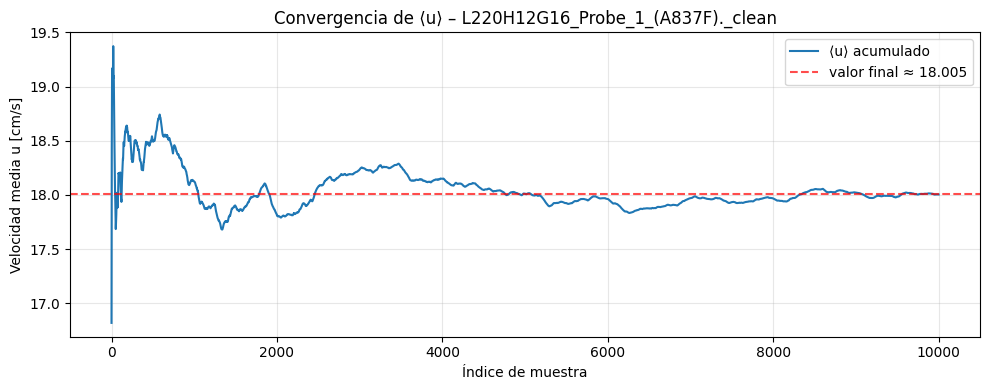

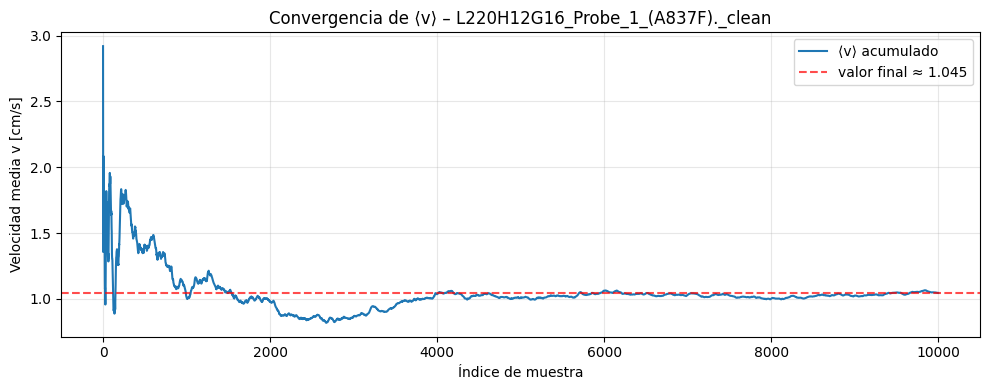

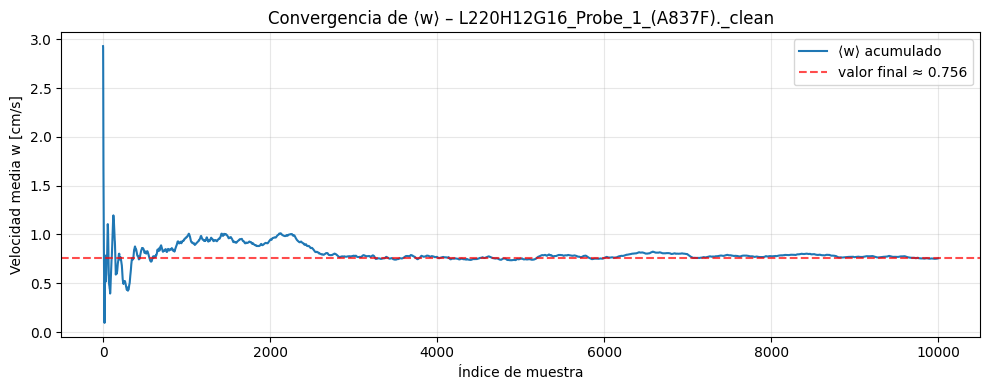

In [10]:
# Frame: verificación de convergencia de las medias en un archivo específico

def plot_running_means_for_file(clean_filename: str,
                                max_points: int = None):
    """
    Para un archivo en ./clean_data:
      - carga u_clean, v_clean, w_clean
      - calcula promedios acumulados
      - grafica ⟨u⟩(t), ⟨v⟩(t), ⟨w⟩(t)
    """
    clean_path = os.path.join(CLEAN_DIR, clean_filename)
    df = pd.read_csv(clean_path, sep="\t")

    base = os.path.splitext(clean_filename)[0]

    # Definimos las columnas clean
    cols_clean = {
        "u": "V1/X/E(cm/s)_clean",
        "v": "V2/Y/N(cm/s)_clean",
        "w": "V3/Z/U(cm/s)_clean",
    }

    for comp, col in cols_clean.items():
        if col not in df.columns:
            print(f"⚠️ Columna {col} no está en {clean_filename}, se omite {comp}.")
            continue

        signal = df[col].values

        if max_points is not None and len(signal) > max_points:
            signal = signal[:max_points]

        rm = running_mean(signal)
        idx = np.arange(len(rm))

        plt.figure(figsize=(10, 4))
        plt.plot(idx, rm, label=f"⟨{comp}⟩ acumulado")
        plt.axhline(rm[-1], color="red", linestyle="--", alpha=0.7,
                    label=f"valor final ≈ {rm[-1]:.3f}")

        plt.xlabel("Índice de muestra")
        plt.ylabel(f"Velocidad media {comp} [cm/s]")
        plt.title(f"Convergencia de ⟨{comp}⟩ – {base}")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Ejemplo de uso manual:
plot_running_means_for_file("L220H12G16_Probe_1_(A837F)._clean.csv", max_points=10000)
